### Want to see when representation is dynamic or stable

In [6]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.pseudo_decoding.belief_partitions.belief_partition_configs import *
import scripts.pseudo_decoding.belief_partitions.belief_partitions_io as belief_partitions_io

import scipy
import argparse
import copy
import itertools

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
args = argparse.Namespace(
    **BeliefPartitionConfigs()._asdict()
)
args.trial_event = "FeedbackOnsetLong"
args.subject = "both"
args.base_output_path = "/data/patrick_res/choice_reward"
args.sig_unit_level = "choice_99th_window_filter_drift"
args.mode = "choice"

In [22]:
all_weights = []
for feat in FEATURES:
    args.feat = feat
    weights = belief_partitions_io.get_weights(args)
    weights["feat"] = feat
    all_weights.append(weights)
all_weights = pd.concat(all_weights)
all_weights["TimeIdx"] = (all_weights.Time * 10).round().astype(int)
all_weights["PrevTimeIdx"] = all_weights.TimeIdx - 1

In [23]:
all_weights

,Time,feat,level_2,pos,weightsdiff,weightsdiff_normed,mean,std,Unnamed: 0,PseudoUnitID,TimeIdx,PrevTimeIdx
0,-1.7,CIRCLE,0,0,0.064032,0.010017,5.088785,6.392482,319,2018061500,-17,-18
1,-1.6,CIRCLE,0,0,0.093095,0.019778,4.704577,4.706978,319,2018061500,-16,-17
2,-1.5,CIRCLE,0,0,0.139513,0.032443,4.469206,4.300249,319,2018061500,-15,-16
3,-1.4,CIRCLE,0,0,0.097266,0.021795,4.603976,4.462737,319,2018061500,-14,-15
4,-1.3,CIRCLE,0,0,0.016129,0.003247,4.774760,4.966881,319,2018061500,-13,-14
...,...,...,...,...,...,...,...,...,...,...,...,...
7222,1.1,SWIRL,218,218,-0.016829,-0.012662,0.226632,1.329059,189,2019082313,11,10
7223,1.2,SWIRL,218,218,-0.000154,-0.000189,0.137340,0.813314,189,2019082313,12,11
7224,1.3,SWIRL,218,218,-0.051643,-0.110417,0.079998,0.467709,189,2019082313,13,12
7225,1.4,SWIRL,218,218,-0.043950,-0.076476,0.084246,0.574687,189,2019082313,14,13


In [24]:
merged = pd.merge(all_weights, all_weights, left_on=["PseudoUnitID", "TimeIdx"], right_on=["PseudoUnitID", "PrevTimeIdx"], suffixes=("_curr", "_prev"))

In [26]:
merged

,Time_curr,feat_curr,level_2_curr,pos_curr,weightsdiff_curr,weightsdiff_normed_curr,mean_curr,std_curr,Unnamed: 0_curr,PseudoUnitID,...,feat_prev,level_2_prev,pos_prev,weightsdiff_prev,weightsdiff_normed_prev,mean_prev,std_prev,Unnamed: 0_prev,TimeIdx_prev,PrevTimeIdx_prev
0,-1.7,CIRCLE,0,0,0.064032,0.010017,5.088785,6.392482,319,2018061500,...,CIRCLE,0,0,0.093095,0.019778,4.704577,4.706978,319,-16,-17
1,-1.7,CIRCLE,0,0,0.064032,0.010017,5.088785,6.392482,319,2018061500,...,SQUARE,0,0,-0.033867,-0.006894,4.673064,4.912658,316,-16,-17
2,-1.7,CIRCLE,0,0,0.064032,0.010017,5.088785,6.392482,319,2018061500,...,TRIANGLE,0,0,0.008276,0.001746,4.767920,4.741054,180,-16,-17
3,-1.7,CIRCLE,0,0,0.064032,0.010017,5.088785,6.392482,319,2018061500,...,RIPPLE,0,0,-0.048421,-0.011402,4.163076,4.246782,196,-16,-17
4,-1.7,CIRCLE,0,0,0.064032,0.010017,5.088785,6.392482,319,2018061500,...,SWIRL,0,0,0.091224,0.017415,4.983460,5.238387,159,-16,-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391611,1.0,SWIRL,212,212,-0.052194,-0.053839,0.372763,0.969443,183,2019082302,...,SWIRL,212,212,-0.033783,-0.030578,0.361305,1.104815,183,11,10
391612,1.1,SWIRL,212,212,-0.033783,-0.030578,0.361305,1.104815,183,2019082302,...,SWIRL,212,212,-0.025515,-0.024694,0.356345,1.033253,183,12,11
391613,1.2,SWIRL,212,212,-0.025515,-0.024694,0.356345,1.033253,183,2019082302,...,SWIRL,212,212,-0.064786,-0.061540,0.359109,1.052740,183,13,12
391614,1.3,SWIRL,212,212,-0.064786,-0.061540,0.359109,1.052740,183,2019082302,...,SWIRL,212,212,-0.126277,-0.119337,0.372329,1.058158,183,14,13


In [30]:
def compute_cosine_sim(x):
    return classifier_utils.cosine_sim(x.weightsdiff_curr, x.weightsdiff_prev)

res = merged.groupby(["feat_curr", "Time_curr"]).apply(compute_cosine_sim).reset_index(name="cosine_sim")

In [31]:
res

,feat_curr,Time_curr,cosine_sim
0,CIRCLE,-1.7,0.185839
1,CIRCLE,-1.6,0.143476
2,CIRCLE,-1.5,0.183264
3,CIRCLE,-1.4,0.202995
4,CIRCLE,-1.3,0.223096
...,...,...,...
379,YELLOW,1.0,0.166910
380,YELLOW,1.1,0.187369
381,YELLOW,1.2,0.195076
382,YELLOW,1.3,0.178475


<Axes: xlabel='Time_curr', ylabel='cosine_sim'>

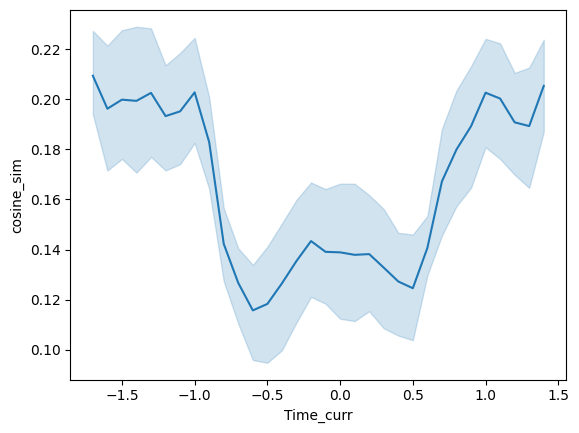

In [32]:
sns.lineplot(res, x="Time_curr", y="cosine_sim")